# Big assignment 1

## Read before you start

* Provide clear and complete answers in code blocks or markdown. You may add as many as you need.
* Always motivate your answers. This can be done in markdown cells, or in comments in code.
* Submit your results via Brightspace. Use the following filename convention: ``StudentName1_snumber1_StudentName2_snumber2_LargeAssignment1.ipynb``.
* Make sure you submit a fully executed version of the notebook file. The teaching assistants will not run/debug your code during grading.
* Questions? Ask them during the workgroups, or see Brightspace for instructions on how to proceed.

In [ ]:
!apt install jags
!pip install pyjags

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  jags
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,644 kB of archives.
After this operation, 3,492 kB of additional disk space will be used.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ jags 4.3.2-1.2204.0 [1,644 kB]
Fetched 1,644 kB in 0s (5,479 kB/s)
Selecting previously unselected package jags.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../jags_4.3.2-1.2204.0_amd64.deb ...
Unpacking jags (4.3.2-1.2204.0) ...
Setting up jags (4.3.2-1.2204.0) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyjags as pj

print('Using PyJAGS v{:s}'.format(pj.__version__))

plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=12)       # legend fontsize
plt.rc('figure', titlesize=30)      # fontsize of the figure title

Using PyJAGS v1.3.8


# 1. Modelling exam results

In this exercise, we'll use some very small data sets and Bayesian modeling to answer some simple research questions. We'll study the performance of students on multiple choice exams (us teachers are obsessed with these type of examples). We'll be using `pyjags` to construct increasingly complex models for such data.

## 1.1. To study or not to study
Suppose we have an exam of $n = 40$ true-or-false questions, and $m = 15$ students that take this test. We observe the following scores on the exam:

$$
\mathbf{k} = (19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33) \enspace,
$$ where $k_i$ is the number of correct answers out of $n$ for student $i$.

If you look closely at these data, it seems as if it captures two different 'types' of students: one type performs reasonably well, whereas the other type reaches only guessing-level performance.

It would be great if we could figure out to which type each student belongs, and what the success rates (i.e., the probabilities of a correct answer) are for the two groups.

The first steps to modelling this situation consists of writing down the generative model, and drawing the corresponding graphical model. The generative model should include (at least) the following:

- $k_i$: the number of questions answered correctly by student $i$.
- $z_i$: the group label for student $i$ (group 0: guessing; group 1: studying).
- $\theta_i$: the probability student $i$ answers correctly.
- $\psi$: the probability of a correct answer for students in group 0.
- $\phi$: the probability of a correct answer for students in group 1.

You may need to add several (hyper-)parameters yourself!

- $p_g$: probability of being in the study group

1. What distribution makes sense for the likelihood $P(k_i \mid n, \ldots)$?

- Binomial distribution - Binomial(k|n,...)
But we need to model it for each group!



2. Write down the generative model for this scenario. Think carefully about:
  - Which variable do you want to learn?
  - Which variable do you want to set to a fixed value (a hyperparameter)?
  - Which variable is observed?
  - Which variables are deterministic transformations of other variables?

Here are two hints:

First, The probability of a correct answer depends on the group a student belongs to ($z_i$). To express this in a generative model, we can use $z_i$ as an _indexing variable_ (this is the same idea as the label variable in a mixture model; that is essentially what we have here!). For example, one could specify:

$$
  \theta_i = \begin{cases}\phi & \text{if $z_i=1$}\\ \psi &\text{if $z_i=0$.}\end{cases}
$$

Second, note that if a student is not in the guessing group, we expect them to perform __better__ than chance level.

- We want to learn about the $z_i$ decribing the students group index number as well as come to conlusion about final values of priors $\psi$ and $\phi$
- Fixed valued hyperparameters should be $p_g$
- Observed variable aka the DATA is the number of correctly answered questions for student i, that is $k_i$, $m$, $n$
- The $\theta_i$ is a transformation of $z_i$


3. Draw the corresponding graphical model. Pay attention to:
  - Which variable is observed (data or hyperparameter),
  - Which is latent (these we want to learn), and
  - Which variables repeat.

4. Write down the application of Bayes' theorem for your model. You do not need to solve the integral in the marginal likelihood; we'll avoid that by using JAGS. You may leave distributions in abstract notation, e.g. $p(k_i \mid n, \ldots)$; you do not have to write down their full expressions.

The posterior distribution follows:

$P(z, ψ, ϕ | k, n)$ ~ $P(k|n, z, ψ, ϕ) P(z,ψ,ϕ)$,

$P(z_i)$ ~ Bernoulli($p_g$)

$P(k_i|n)$ ~ Binomial($\theta_i$, n)  

$\psi$ = 0.5

$\phi$ ~ Uniform(0.5,1)


5. Do a so-called _prior predictive check_: Sample random values for the latent variables of your model (using the `numpy.random` module or with JAGS) and use them to generate a new vector $\hat{\mathbf{k}}$. Does it exhibit the properties you want it to have, when you compare it to the actual $\mathbf{k}$?

In [ ]:
n_students = 15
m_questions = 40
psi = 0.5
phi = np.random.uniform(0.5, 1.0, n_students)                                     # Ready for case if everybody studied
p_guess = 0.56                                                                    # I know this is not non-informative priors... but I think it is fair to assume its okay after running multiple times and seeing its fair
p_study = 1 - p_guess
z = np.random.choice([0, 1], size=n_students, p=[p_guess, p_study])
k = np.zeros(n_students, dtype=int)

for i in range(n_students):
  if z[i] == 0:
    k[i] = np.random.binomial(40, psi)
  else:
    k[i] = np.random.binomial(40, phi[i])

# Running some summary for fast validity checks
counter = 0
for result in k:
  if result < m_questions * p_guess:                                              # Student didn't study rather
    counter += 1

print(f"Studied: {n_students - counter}")
print(f"Guessed: {counter}")

Studied: 8
Guessed: 7


In my comment, with p_guess = 0.56 I aim to prevent from big homogenosity of one particular group in the sample. Thats what I considered in original vector k. Note that with p_guess 0.5 it used to be often dominated by study group.

6. Implement the model in JAGS and train it on the available data.

In [ ]:
%%time
n = 40
k = [19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33]
m = len(k)
theta = np.zeros(m, dtype=float)

jags_model = '''
model {
  psi <- 0.5
  phi ~ dunif(0.5, 1)
  for (i in 1:m) {
      z[i] ~ dbern(0.44)
  }
  for (i in 1:m) {
      theta[i] <- z[i] * phi + (1 - z[i]) * psi
  }
  for (i in 1:m) {
      k[i] ~ dbin(theta[i], n)
  }
}
'''

# Prepare data
data = {'k': k, 'm': m, 'n': n}

# How long we sample
num_iter = 10000
# How many distinct sampling runs
num_chains = 4

model = pj.Model(jags_model, data=data, chains=num_chains)
samples = model.sample(num_iter, vars=['z', 'phi', 'theta'])

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:01, remaining 0:00:00
CPU times: user 775 ms, sys: 127 ms, total: 903 ms
Wall time: 823 ms


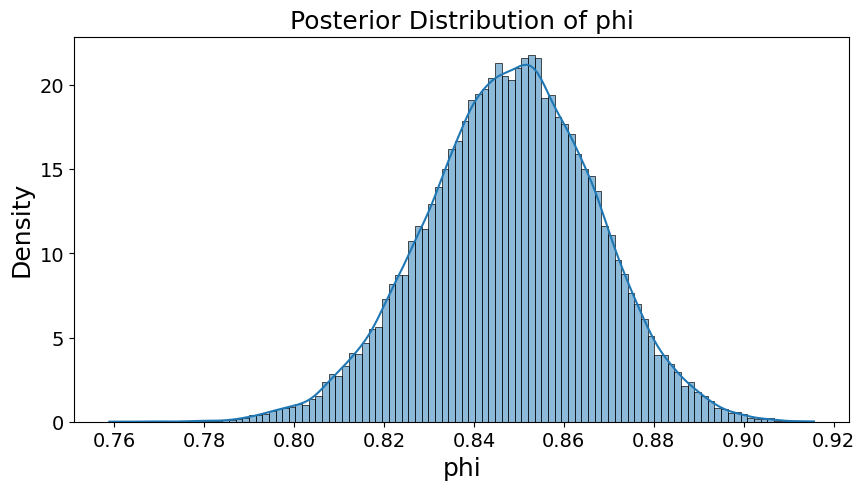

In [ ]:
# Flatten the 'phi' samples
phi_samples = samples['phi'].flatten()
# Now plot using the flattened samples
plt.figure(figsize=(10, 5))
import seaborn as sns
sns.histplot(phi_samples, kde=True, stat='density')
plt.title('Posterior Distribution of phi')
plt.xlabel('phi')
plt.ylabel('Density')
plt.show()

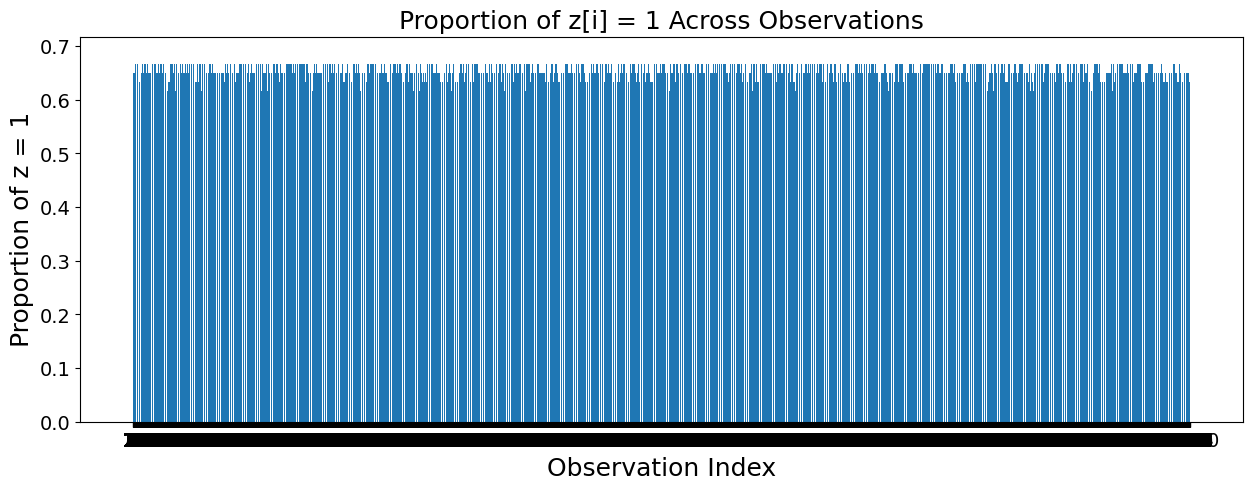

In [ ]:
# Calculate the mean across chains and iterations for each 'z[i]'
z_proportions = np.mean(samples['z'], axis=(0, 2))  # This collapses across the first and last dimensions, leaving you with the average over all samples for each 'i'
# Plot the proportions of 'z = 1'
plt.figure(figsize=(15, 5))
plt.bar(range(1, len(z_proportions) + 1), z_proportions)
plt.title('Proportion of z[i] = 1 Across Observations')
plt.xlabel('Observation Index')
plt.ylabel('Proportion of z = 1')
plt.xticks(range(1, len(z_proportions) + 1))  # Adjust ticks if necessary
plt.show()

7. Use the code below to make a ridge plot of $\theta_i$. Adapt the code to also show the maximum likelihood estimates for $\theta_i$ as a red vertical line, for each student. Are the distributions for $\theta_i$ consistent with MLEs?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from scipy.stats import gaussian_kde

def ridge_plot(samples, xlimits, suptitle, xlabel, ylabel, mle_estimates=None):
    """Make a ridge-plot figure.

    This function makes a ridge plot. It consists of a number of visually
    overlapped smoothed histograms.

    The dashed lines indicate the observed treatment effects, while the
    histograms show what our model estimates.

    Args:
        samples: A numpy array of size m x num_samples x num_chains
        xlimits: the horizontal limits of the figures
        suptitle: the title to put above the figure
        xlabel: the name of the x-label
        ylabel: the name of each row
        mle_estimates: Maximum likelihood estimates for theta_i
    """
    colors = plt.cm.get_cmap('inferno')
    J = samples.shape[0]
    gs = grid_spec.GridSpec(J, 1)
    fig = plt.figure(figsize=(10, 10))

    i = 0
    xmin, xmax = xlimits
    theta = np.linspace(xmin, xmax, num=200)

    ax_objs = []
    for i in range(J):
        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].hist(samples[i, :, :].flatten(), density=True, bins=100,
                         histtype='stepfilled', edgecolor='k', linewidth=1.2, color=colors(i/J))

        # setting uniform x and y lims
        ax_objs[-1].set_xlim(xmin, xmax)
        ax_objs[-1].set_ylim(bottom=0)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        if i != J-1:
            ax_objs[-1].set_xticklabels([])
        ax_objs[-1].text(xmin, 0.001, f'{ylabel} {i+1}',fontsize=14, ha="right")

        spines = ["top", "right", "left"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
        ax_objs[-1].set_yticks([])

        # Plot MLE estimates if provided
        if mle_estimates is not None:
            ax_objs[-1].axvline(x=mle_estimates[i], color='red', linestyle='--')

        i += 1

    ax_objs[-1].set_xlabel(xlabel)
    gs.update(hspace=-0.3)
    plt.suptitle(suptitle, fontsize=24)
    return ax_objs

<ipython-input-61-5f340b708d2b>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('inferno')


[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: xlabel='Theta Value'>]

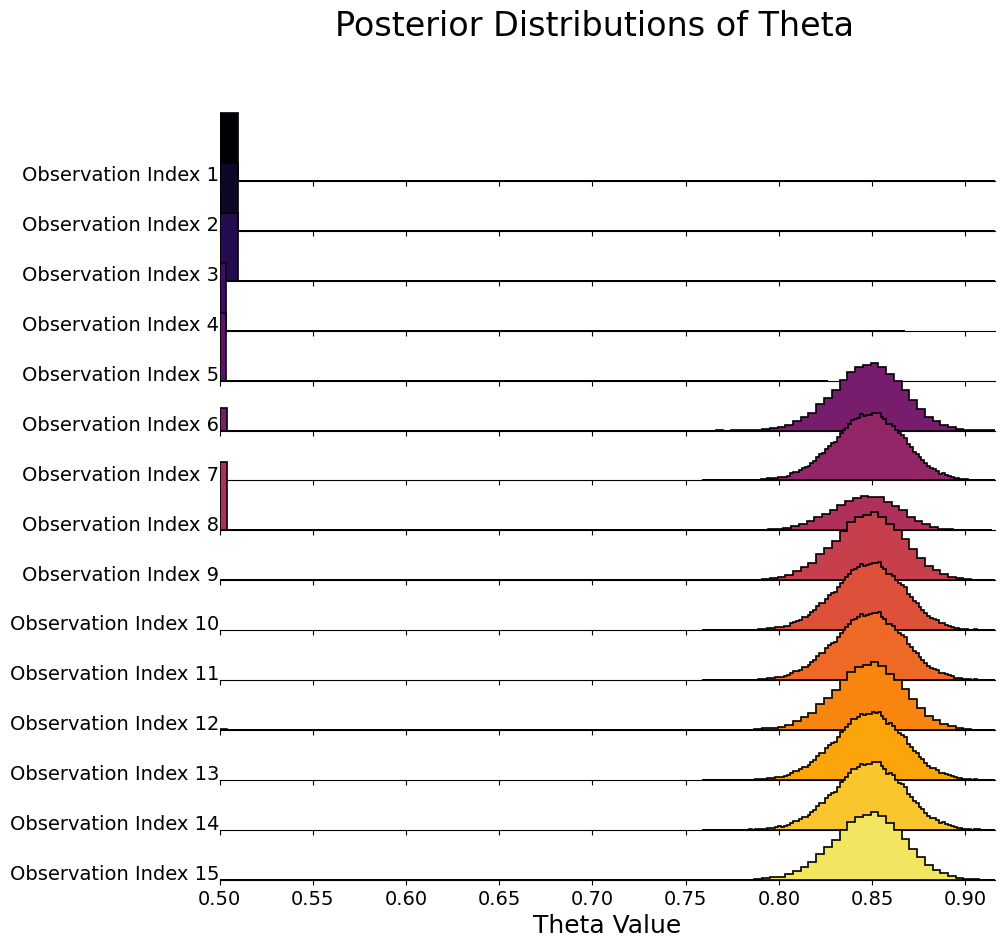

In [ ]:
theta_samples = samples['theta']
# Number of chains and iterations (assuming these are the second and third dimensions)
num_samples = theta_samples.shape[1] * theta_samples.shape[2]

# Reshape the array to (m x num_samples x num_chains)
theta_samples_reshaped = theta_samples.reshape((m, num_samples, 1))  # Num chains is 1 since we combine chains

# Set the limits for your plot based on the range of your θi samples.
# For example, if your samples are probabilities, they will range from 0 to 1.
xlimits = (np.min(theta_samples), np.max(theta_samples))

# Now, 'theta_samples_reshaped' is ready to be passed to the ridge plot function
ridge_plot(theta_samples_reshaped, xlimits, 'Posterior Distributions of Theta', 'Theta Value', 'Observation Index')

8. What are the posterior probabilities that a student has studied, for each of the $m$ students?

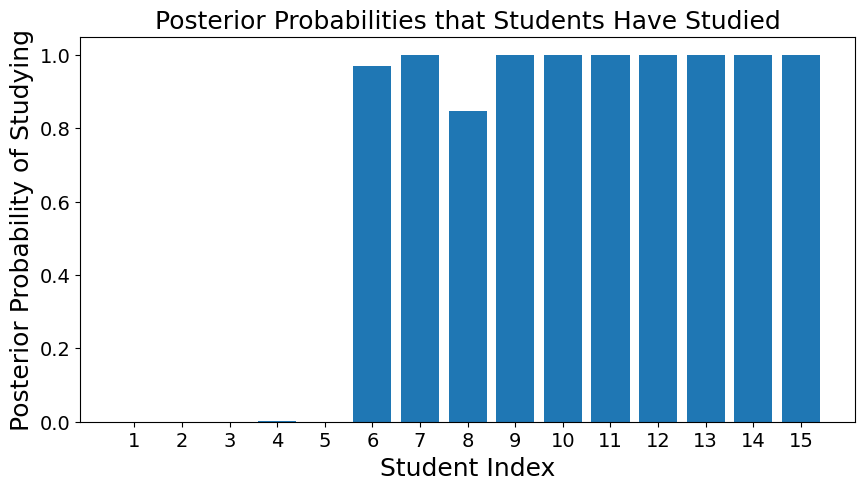

In [ ]:
model_one_z = samples['z']
posterior_prob_studied = samples['z'].mean(axis=(1, 2))
plt.figure(figsize=(10, 5))
plt.bar(range(1, m + 1), posterior_prob_studied)
plt.xlabel('Student Index')
plt.ylabel('Posterior Probability of Studying')
plt.title('Posterior Probabilities that Students Have Studied')
plt.xticks(range(1, m + 1))
plt.show()

## 1.2. Individual variability

The previous model makes a strong assumption: students that did study, all have the _same_ probability of answering a question correctly. That does not seem very realistic.

1. Alter your generative model and your JAGS implementation to capture differences in performance among students that _did_ study. Make explicit what you changed compared to the previous model! In addition, make another ridge plot to show your updated results.

In [ ]:
%%time
n = 40
k = [19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33]
m = len(k)

# JAGS model with normal distribution for group performance among students who studied
jags_model = '''
model {
  # Priors for the parameters
  psi <- 0.5 # Fixed probability of guessing correctly for those who didn't study
  mu_phi_studied ~ dunif(0.5, 1)  # Mean performance for those who studied
  sigma_phi_studied ~ dunif(0, 1)  # Standard deviation for those who studied

  # Precision of the normal distribution for individual performances among students who studied
  tau_phi_studied <- pow(sigma_phi_studied, -2)

  # Prior for the latent group indicator
  for (i in 1:m) {
      z[i] ~ dbern(0.5)
  }

  for (i in 1:m) {
    # For students who studied
    phi_studied[i] ~ dnorm(mu_phi_studied, tau_phi_studied)

    # Use the 'studied' array as a switch
    phi[i] <- psi * (1 - z[i]) + phi_studied[i] * z[i]
  }

  # Likelihood for observed counts
  for (i in 1:m) {
    k[i] ~ dbin(phi[i], n)
  }
}
'''

# Prepare data
data = {'k': k, 'm': m, 'n': n, 'z': z}

# How long we sample
num_iter = 10000
# How many distinct sampling runs
num_chains = 4

# Initial values for the parameters
init_values = {'mu_phi_studied': 0.75, 'sigma_phi_studied': 0.1}

model = pj.Model(jags_model, data=data, chains=num_chains, init=init_values)
samples2 = model.sample(num_iter, vars=['phi', 'z'])

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:02, remaining 0:00:00
CPU times: user 1.78 s, sys: 7.15 ms, total: 1.79 s
Wall time: 1.81 s


In [ ]:
%%time
n = 40
k = [19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33]
m = len(k)

# JAGS model with normal distribution for group performance among students who studied
jags_model = '''
model {
  # Fixed probability for those who didn't study
  psi <- 0.5
  # Hyperparameters for the normal distribution on the logit scale
  mu_logit_phi ~ dunif(-5, 5)  # Logit mean can be very broad
  sigma_logit_phi ~ dunif(0, 5)  # Logit standard deviation can be very broad

  # Precision of the normal distribution for logit_phi
  tau_logit_phi <- pow(sigma_logit_phi, -2)

  for (i in 1:m) {
    # Latent variable for study indicator
    z[i] ~ dbern(0.5)

    # Logit-normal distribution for the probability
    logit_phi_studied[i] ~ dnorm(mu_logit_phi, tau_logit_phi)
    # Transform back to probability scale
    phi_studied[i] <- ilogit(logit_phi_studied[i])

    # Final probability, taking into account whether the student studied
    phi[i] <- psi * (1 - z[i]) + phi_studied[i] * z[i]

    # Likelihood for observed counts
    k[i] ~ dbin(phi[i], n)
  }
}
'''

# Prepare data
data = {'k': k, 'm': m, 'n': n, 'z': z}

# How long we sample
num_iter = 10000
# How many distinct sampling runs
num_chains = 4

# Initial values for the parameters
init_values = [{'mu_logit_phi': 0, 'sigma_logit_phi': 1} for _ in range(num_chains)]

model = pj.Model(jags_model, data=data, chains=num_chains, init=init_values)
samples = model.sample(num_iter, vars=['phi', 'z'])

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:01, remaining 0:00:00
CPU times: user 1.65 s, sys: 6.24 ms, total: 1.65 s
Wall time: 1.69 s


2. Now print again the probabilities that each individual student has studied; print both the probability according to your first model and according to your second model.



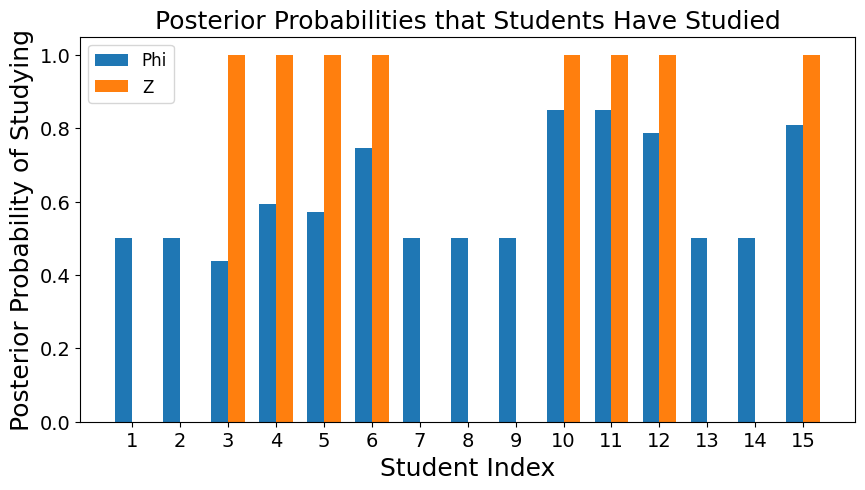

In [ ]:
# Assuming 'samples' is your data structure containing 'phi' and 'z', and 'm' is the number of students
posterior_prob_studied_phi = samples['phi'].mean(axis=(1, 2))
posterior_prob_studied_z = samples['z'].mean(axis=(1, 2))
m = len(posterior_prob_studied_phi)  # or however many students there are

# Set up the figure and axes for plotting
plt.figure(figsize=(10, 5))

# Generate an array with the positions of the bars on the x-axis
indices = np.arange(1, m + 1)
width = 0.35  # Width of the bars

# Plotting both sets of bars side-by-side
plt.bar(indices - width/2, posterior_prob_studied_phi, width=width, label='Phi')
plt.bar(indices + width/2, posterior_prob_studied_z, width=width, label='Z')

# Adding labels and title
plt.xlabel('Student Index')
plt.ylabel('Posterior Probability of Studying')
plt.title('Posterior Probabilities that Students Have Studied')

# Setting the x-ticks to be in the middle of the two sets of bars
plt.xticks(indices)
plt.legend()

# Show the plot
plt.show()

You should see that some probabilities have changed.

Why did adding the individual variability to the probability of a correct answer after studying, change the probability for students who performed poorly?

It may be that if the certain threshold is exceeded for phi (talking about this transformation) it infers that the performance is actually good.

## 1.3. Easy and tough exam questions

The previous model assumed that all questions were equal in difficulty. Of course, this is rarely the case in practice. Here, we construct a new model in which we represent both _student ability_ and _question difficulty_.

To be able to model the difficulty of questions, we will not work with the aggregate results of the test (that is, the number of questions correct, previously $k_i$), but with the results for the individual questions. Now, $k_{ij}=1$ indicates that student $i$ answered question $j$ correctly. We will assume the probability of a question being answered correctly can be written as

$$
    \theta_{ij} = p_i q_j \enspace,
$$

in which $p_i$ is the probability student $i$ answers a question correctly, and $q_j$ is the probability question $j$ gets answered correctly. As you can see, even a student who is very smart ($p_i\approx 1$) might not answer correctly if a question is very difficult ($q_j\approx 0$).

Below are the results (observations) for $m=10$ students making $n=20$ questions.

In [ ]:
k = np.array([[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0 ],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

m, n = k.shape

1. Construct a generative model by which we can learn the individual student performances $p_i$ as well as the question difficulties $q_j$.

2. Implement your model in JAGS. Visualize the posterior estimates of each $p_i$ and $q_j$ in a way you think is appropriate.

In [ ]:
%%time

jags_model3 = '''
model {
    for (i in 1:m) {
        p[i] ~ dbeta(1, 1)  # Assuming uniform prior for demonstration
    }
    for (j in 1:n) {
        q[j] ~ dbeta(1, 1)  # Assuming uniform prior for demonstration
    }
    for (i in 1:m) {
        for (j in 1:n) {
            theta[i,j] <- p[i] * q[j]
            k[i,j] ~ dbern(theta[i,j])
        }
    }
}
'''

data = {
    'k': k,
    'm': m,
    'n': n
}

# How long we sample
num_iter = 10000
# How many distinct sampling runs
num_chains = 3
model3 = pj.Model(jags_model3, data=data, chains=num_chains)
samples3 = model3.sample(num_iter, vars=['p','q'])

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 30000 of 30000, elapsed 0:00:04, remaining 0:00:00
CPU times: user 4.3 s, sys: 10.5 ms, total: 4.31 s
Wall time: 4.39 s


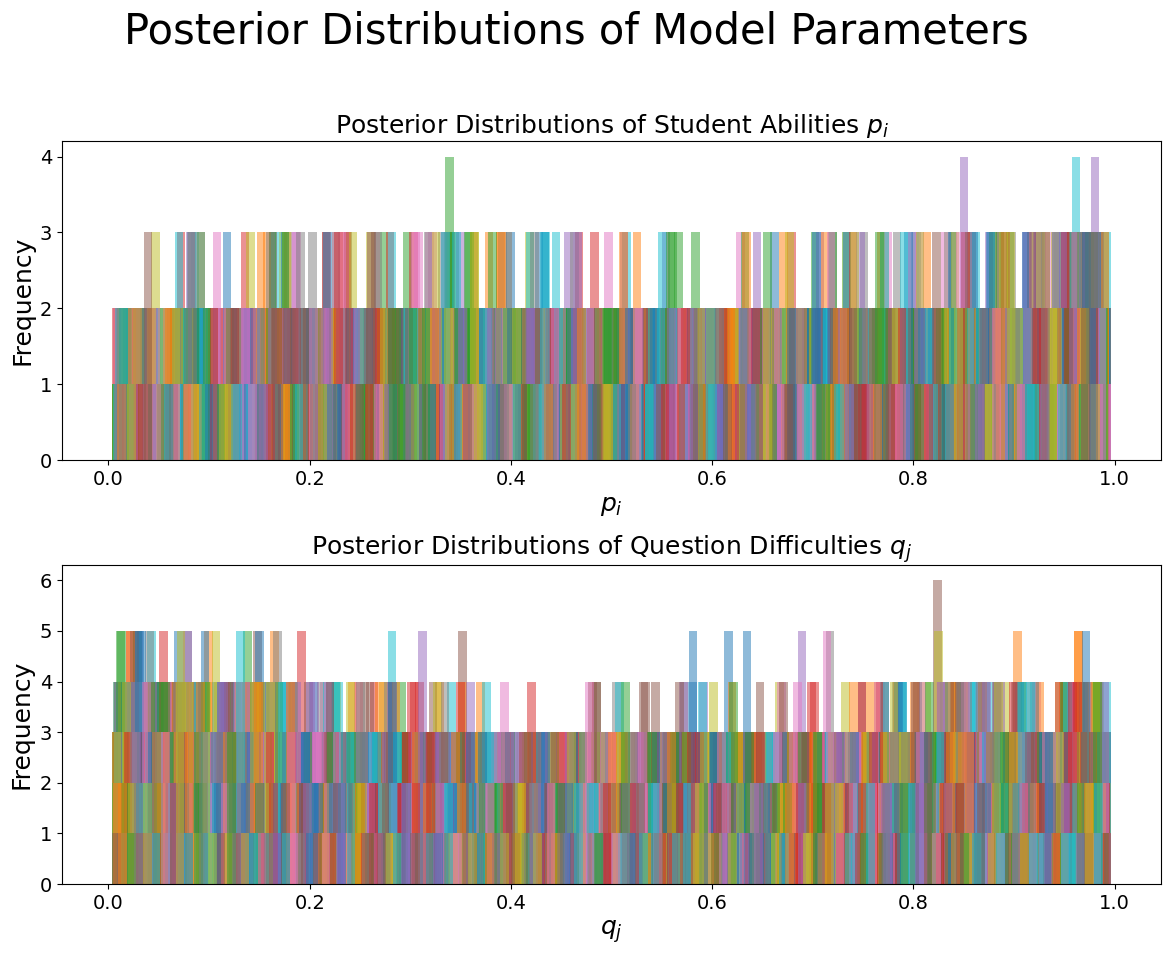

In [ ]:
thin_factor = 10
p_samples = samples3['p']
q_samples = samples3['q']
p_thinned = p_samples[:, ::thin_factor]
q_thinned = q_samples[:, ::thin_factor]
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Posterior Distributions of Model Parameters')

# Histograms for student abilities
for i in range(p_thinned.shape[1]):
    axes[0].hist(p_thinned[:, i], bins=30, alpha=0.5, label=f'Student {i+1}')
axes[0].set_title('Posterior Distributions of Student Abilities $p_i$')
axes[0].set_xlabel('$p_i$')
axes[0].set_ylabel('Frequency')

# Histograms for question difficulties
for j in range(q_thinned.shape[1]):
    axes[1].hist(q_thinned[:, j], bins=30, alpha=0.5, label=f'Question {j+1}')
axes[1].set_title('Posterior Distributions of Question Difficulties $q_j$')
axes[1].set_xlabel('$q_j$')
axes[1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()

3. According to your model, which students performed best, and which questions where the most difficult?

Tip: for this 'sorting', it might be easiest to compute for each $p_i$ or $q_j$ the _mode_ of the distribution and sort according to this.

---
# 2. Let's milk this further with Bayesian regression

In an attempt to produce productivity, farmer Fred decides to start cuddling his cows for a testing period of one month. For each cow, Fred writes down the number of cuddles she received ($x_i$) as well as the total amount of milk they produced that month ($y_i$; in liters).

The following code snippet loads and visualizes Fred's data set.

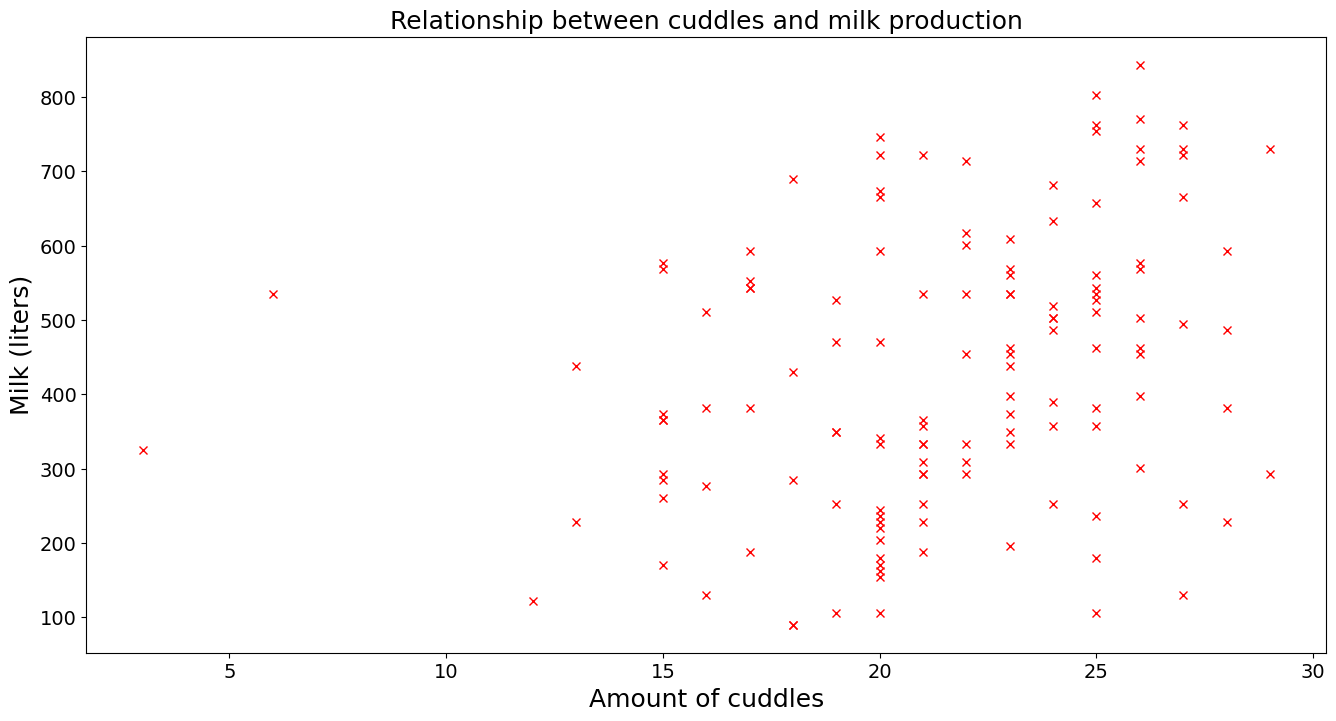

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('cow_cuddles_fred.csv', delimiter=';', decimal=',', header=None)
x = df[0].to_numpy()
y = df[1].to_numpy()
n = len(y)


plt.figure(figsize=(16, 8))
plt.plot(x, y, 'rx')
plt.xlabel('Amount of cuddles')
plt.ylabel('Milk (liters)')
plt.title('Relationship between cuddles and milk production');

1. Implement a Bayesian linear regression model in JAGS.

In [ ]:
%%time

code = '''
model {
    # Priors
    alpha ~ dnorm(0.0, 1.0e-4)
    beta ~ dnorm(0, 1/pow(10,2))
    sigma ~ dunif(0, 100)

    for (i in 1:N) {
        y[i] ~ dnorm(mu[i], tau)
        mu[i] <- alpha + beta * x[i]
    }

    # Precision is the reciprocal of variance
    tau <- pow(sigma, -2)
}
'''

data = {
    'x': x,
    'y': y,
    'N': len(data)}
num_samples = 1000
num_chains = 4

m = pj.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=['alpha', 'beta', 'sigma', 'mu'])
alpha_samples = samples['alpha']
beta_samples = samples['beta']
sigma_samples = samples['sigma']

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
CPU times: user 37.3 ms, sys: 0 ns, total: 37.3 ms
Wall time: 53.5 ms


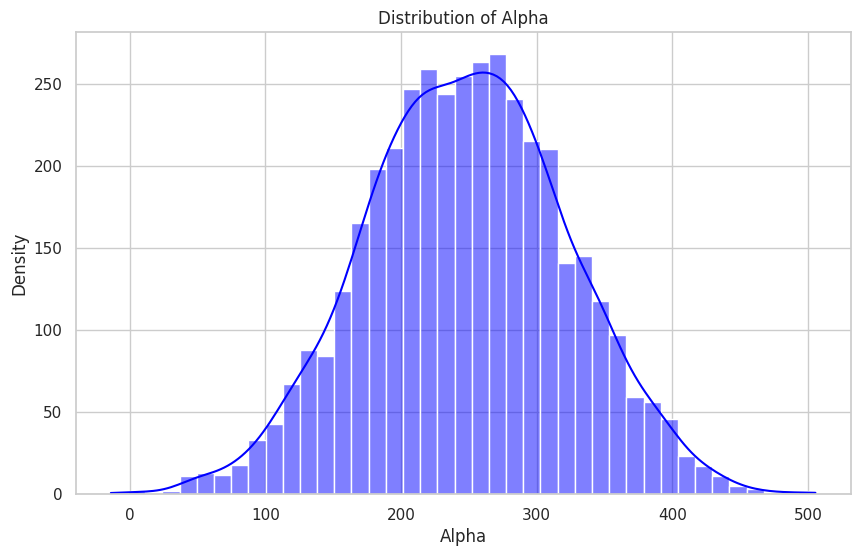

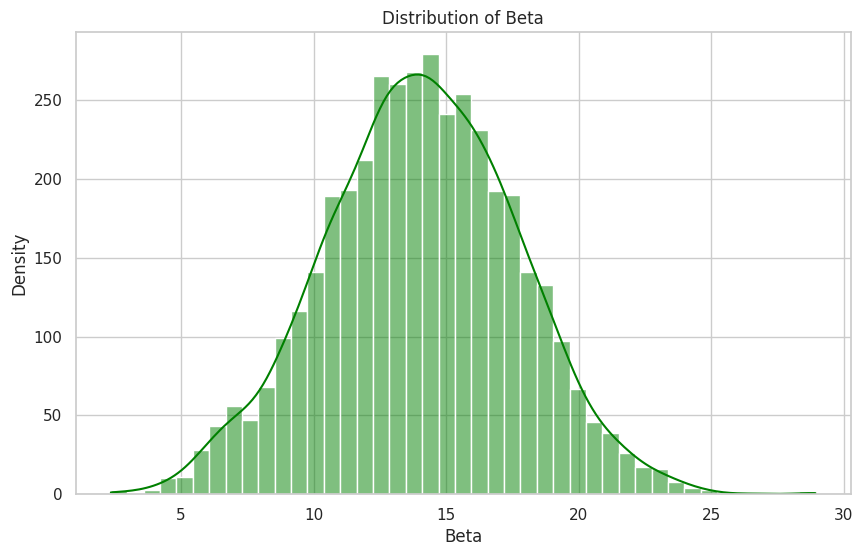

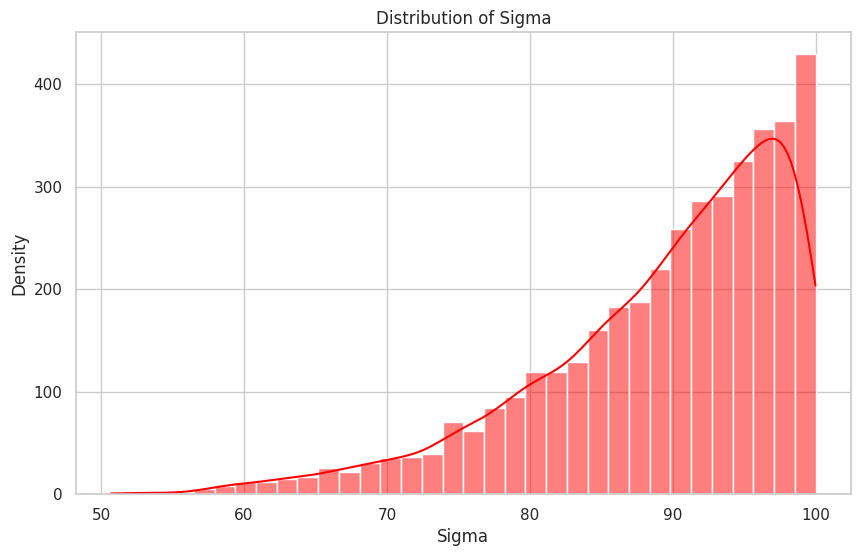

In [ ]:
# Create a DataFrame from the samples
samples_df = pd.DataFrame({
    'alpha': alpha_samples.flatten(),
    'beta': beta_samples.flatten(),
    'sigma': sigma_samples.flatten()
})

# Plotting the distribution of alpha
plt.figure(figsize=(10, 6))
sns.histplot(samples_df['alpha'], kde=True, color='blue')
plt.title('Distribution of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.show()

# Plotting the distribution of beta
plt.figure(figsize=(10, 6))
sns.histplot(samples_df['beta'], kde=True, color='green')
plt.title('Distribution of Beta')
plt.xlabel('Beta')
plt.ylabel('Density')
plt.show()

# Plotting the distribution of sigma
plt.figure(figsize=(10, 6))
sns.histplot(samples_df['sigma'], kde=True, color='red')
plt.title('Distribution of Sigma')
plt.xlabel('Sigma')
plt.ylabel('Density')
plt.show()

2. Use your MCMC samples to visualize the posterior distribution of $\mu=w_0+w_1 x$ for a range of $x$, e.g., `x_plot = np.linspace(0, 30, num=100)`, by showing the posterior expectation and the 95% HDI (see Lecture 6).

Tip: To construct the posterior of $\mu$, you will need the samples of the regression weights ($w_0$ and $w_1$). You could, for every MCMC sample $s$, take $w_0^{(s)}$ and $w_1^{(s)}$ and construct the vector $\mathbf{\mu}^{(s)}$ for each (this vector is of length 100, as `x` was constructed to have that length). However, doing this in a `for` loop can be very slow! It is much faster (i.e., more than 100 times) to add/multiply entire `numpy` matrices/arrays at once.

(4000,)
(4000,)


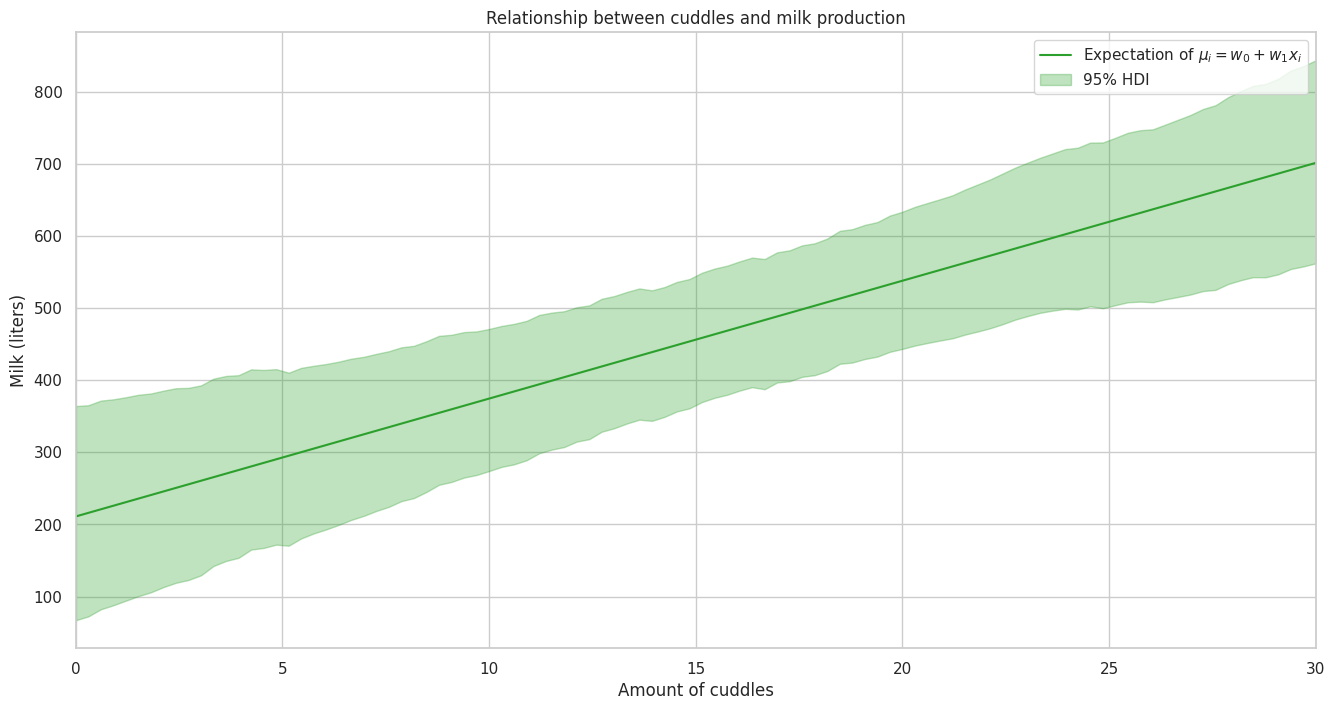

In [ ]:
import arviz as az

# Assuming some synthetic values for w0_samples and w1_samples for demonstration
np.random.seed(42)
num_samples = 1000
num_chains = 3
w0_samples = alpha_samples
w1_samples = beta_samples

# Prepare the x range for plotting
m = 100
x_plot = np.linspace(0, 30, num=m)

# Calculate mu for each sample and each x
mu_samples = np.outer(w1_samples, x_plot) + w0_samples[:, None]
# Calculate the mean and HDI for each x
mu_exp = np.mean(mu_samples, axis=0)
mu_hdi = np.array([az.hdi(mu_samples[:, i], hdi_prob=0.95) for i in range(m)])

# Plotting
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Expectation of mu
ax.plot(x_plot, mu_exp, color='tab:green', label=r'Expectation of $\mu_i = w_0 + w_1 x_i$')

# 95% HDI
ax.fill_between(x_plot, mu_hdi[:, 0], mu_hdi[:, 1], color='tab:green', alpha=0.3, label='95% HDI')

ax.legend()
plt.xlabel('Amount of cuddles')
plt.ylabel('Milk (liters)')
plt.title('Relationship between cuddles and milk production')
ax.set_xlim([x_plot[0], x_plot[-1]])
plt.show()

---
__IMPORTANT__

Something we have not discussed at length is the relationship between our priors and the _scale_ of the data. If you have used a fairly standard prior for your regression weights, such as $w_1 \sim \text{Gaussian}(0, 1)$, you are saying in your prior that you expect only _small_ changes to the amount of milk as a function of an increase in number of cuddles. However, the amount of milk is measured in _hundreds_ of liters. If there indeed is an effect, that means that $w_1$ could have a true value such as 20 (for every additional cuddle, 20 more liters produced) -- which is extremely unlikely under the $\text{Gaussian}(0, 1)$ prior.

The result of such a 'wrong' prior specification can be that the model learns there is almost no effect, and that all observations are just explained by a (nearly) horizontal regression line and a large measurement noise $\sigma$ (the standard deviation of the Gaussian likelihood).

If this happens in your analysis, you have used a prior that is too restrictive (or we simply don't have enough data). It is easily fixed; just make your priors _wider_. For example, use $\text{Gaussian}(0, \sigma=10)$ instead (remember that in JAGS that would be `dnorm(0, 1/pow(10,2))`.

Make sure your posterior expectation of the regression looks reasonable before proceeding!

---

3. Make a histogram of the posterior of the standard deviation $\sigma$. Does it show reasonable values compared to your previous figure (for example, at $x=20$, our observations range from roughly 80 to 750; our standard deviation therefore should not be 4, or 2000)?

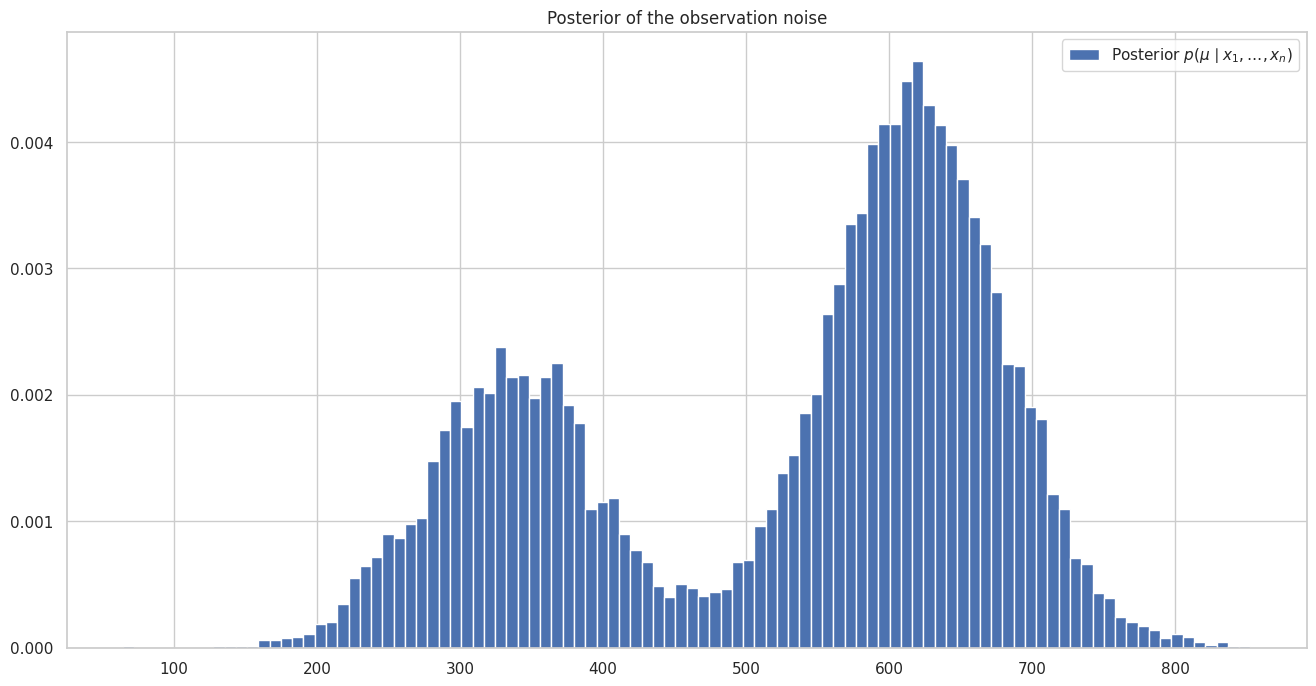

In [ ]:
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.hist(samples['mu'].flatten(), density=True, bins=100,
        label=r'Posterior $p(\mu \mid x_1, \ldots, x_n)$')
ax.legend()
ax.set_title('Posterior of the observation noise');

The previous questions asked you to visualize the posterior distributions of the vector $\mu$ and the scalar $\sigma$. But to know what happens when Fred cuddles a new cow for 40 times ($x^*=40$), we need the _posterior predictive_ distribution instead.

4. Plot a histogram of the (approximated) posterior predictive distribution: $p(y^* \mid x^*, x_1, \ldots, x_n)=\int p(y^* \mid w_0, w_1, \sigma, x^*)p(w_0, w_1, \sigma \mid x_1, \ldots, x_n) \text{d}w_0 \text{d}w_1 \text{d}\sigma$. In the same figure, plot another histogram (with a different color) of $\mu^*$, and a vertical line (using `axvline`) with the posterior expectation of $\mu^*$.

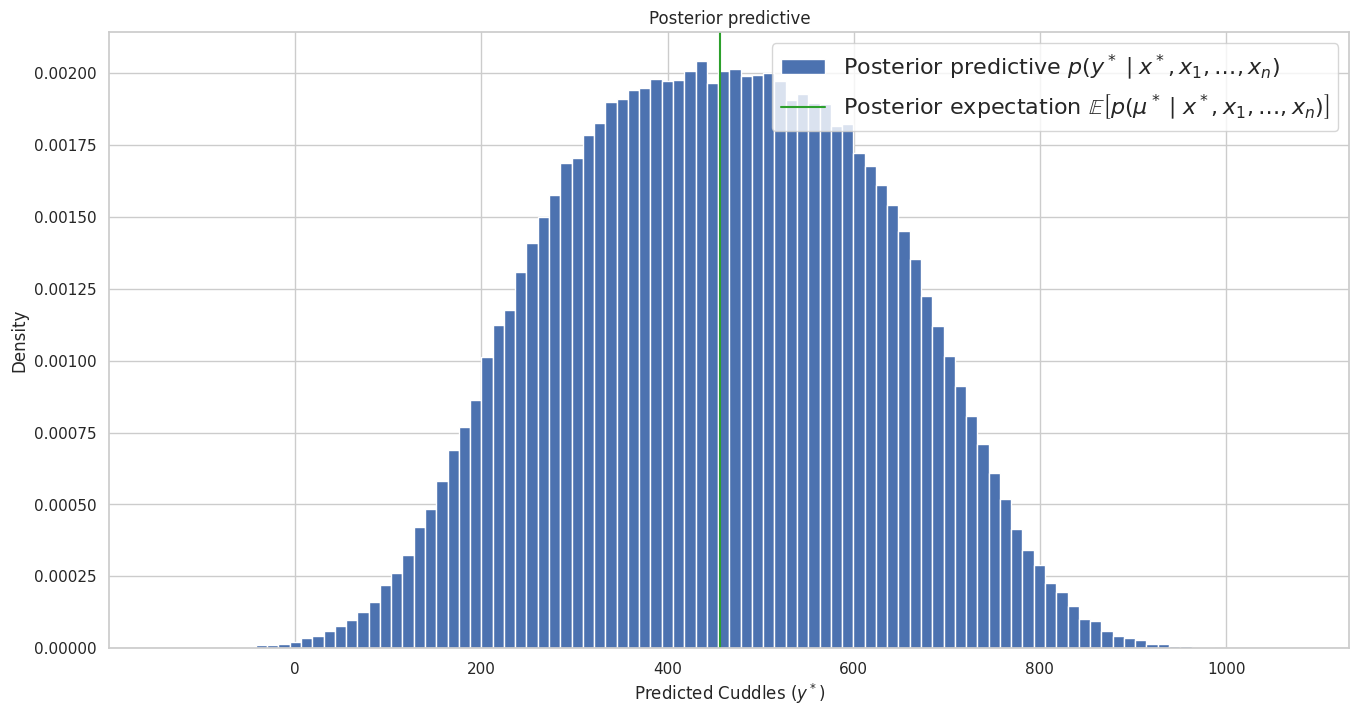

In [ ]:
x_pred = 40

y_pred = np.random.normal(loc=mu_exp[:, None], scale=sigma_samples.flatten())

plt.figure(figsize=(16,8))
ax = plt.gca()
ax.hist(y_pred.flatten(), density=True, bins=100,
        label='Posterior predictive $p(y^* \mid x^*, x_1, \ldots, x_n)$')
ax.axvline(x=np.mean(y_pred), color='tab:green',
           label=r'Posterior expectation $\mathbb{E}\left[p(\mu^* \mid x^*, x_1, \ldots, x_n)\right]$')
ax.legend(fontsize=16)
ax.set_title('Posterior predictive')
plt.xlabel('Predicted Cuddles ($y^*$)')
plt.ylabel('Density')
plt.show()

Neighbouring farmer Francesco learns of Fred's results and decides to start cuddling her cows as well. She follows a similar procedure, and below you can see her observations.

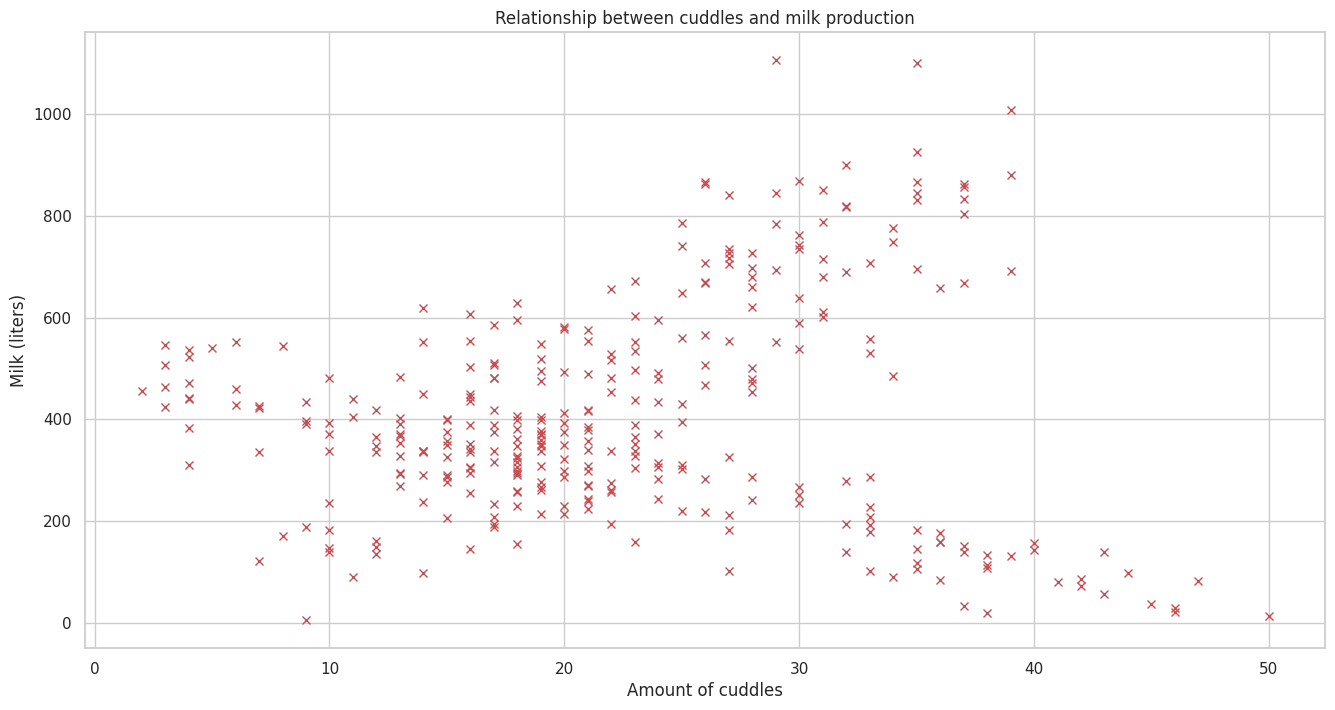

In [ ]:
import pandas as pd

df = pd.read_csv('cow_cuddles_francesca.csv', delimiter=';', decimal='.', header=None)
x = df[0].to_numpy()
y = df[1].to_numpy()
n = len(y)

plt.figure(figsize=(16, 8))
plt.plot(x, y, 'rx')
plt.xlabel('Amount of cuddles')
plt.ylabel('Milk (liters)')
plt.title('Relationship between cuddles and milk production');

Remarkably, the effect is a lot less clear than it was for Fred. In fact, it seems like there are two trends occurring in parallel: one group of cows benefits from cuddles, just like with Fred, but another group of cows seems to produce _less_ milk after receiving cuddles. Perhaps these are a different breed that are not so appreciative of hugging people?

5. Anyway, demonstrate that modelling these data with your Bayesian linear regression model leads to poor predictions, by showing the actual observations at $x=35$ and the posterior predictive distribution.

In [ ]:
import pyjags

code = '''
model {
    for (i in 1:N) {
        y[i] ~ dnorm(mu[i], tau)
        mu[i] <- alpha + beta * x[i]
    }
    alpha ~ dnorm(0, 0.01)
    beta ~ dnorm(0, 0.01)
    sigma ~ dunif(0, 50)
    tau <- pow(sigma, -2)
}
'''

# Prepare your data for the model
data = {
    'x': x,
    'y': y,
    'N': n
}

# Specify the number of samples and chains
num_samples = 1000
num_chains = 4

# Run the model and sample from the posterior
m = pyjags.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=['alpha', 'beta', 'sigma'])

# After sampling, you would generate posterior predictive samples for x=35
# This code is an example and won't run directly in this environment
x_new = 35
y_pred_samples = samples['alpha'] + samples['beta'] * x_new

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00


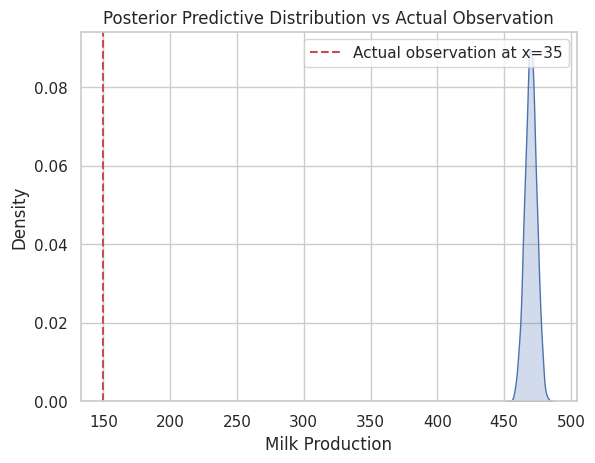

In [ ]:
y_actual = y[35]

# Plotting posterior predictive distribution
sns.kdeplot(y_pred_samples.flatten(), fill=True)
plt.axvline(y_actual, color='r', linestyle='--', label='Actual observation at x=35')
plt.legend()
plt.title('Posterior Predictive Distribution vs Actual Observation')
plt.xlabel('Milk Production')
plt.ylabel('Density')
plt.show()

To better model these observations, we need a _mixture model_. However, instead of a Gaussian mixture model like in the lecture, we now need a Bayesian linear regression mixture model.

6. Write down the generative model for the Bayesian linear regression mixture model. You may assume there are $K=2$ components.

7. Implement your model in JAGS. Make sure to consider the tips in Lecture 6 on keeping the components identifiable!

__Note__: As mentioned in the lecture, this model can take quite a bit longer to sample. My solution took about a minute on a Google colab environment.

In [ ]:
%%time

code = '''
model {
    mu_alpha <- 0
    mu_beta <- 0
    tau_alpha <- 1.0E-4
    tau_beta <- 1.0E-4


    # Hyperpriors for mixture probabilities
    pi ~ ddirch(alpha[1:2])

    # Priors for regression parameters of each component
    for (k in 1:2) {
        alpha[k] ~ dnorm(mu_alpha, tau_alpha)
        beta[k] ~ dnorm(mu_beta, tau_beta)
        sigma[k] ~ dunif(0, 100)
        tau[k] <- pow(sigma[k], -2)
    }

    # Model likelihood for each observation
    for (i in 1:N) {
        # Categorical latent variable for mixture component assignment
        z[i] ~ dcat(pi[1:2])

        # Likelihood for observation given component assignment
        y[i] ~ dnorm(mu[i], tau[z[i]])

        # Mixture of regressions
        mu[i] <- alpha[z[i]] + beta[z[i]] * x[i]
    }
}
'''

data = {
    'x': x,
    'y': y,
    'N': n,
    'alpha': [1, 1],
}
num_samples = 1000
num_chains = 4

m = pj.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=['pi', 'alpha', 'beta', 'sigma', 'z'])

adapting: iterations 4000 of 4000, elapsed 0:00:04, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:04, remaining 0:00:00
CPU times: user 8.65 s, sys: 55.8 ms, total: 8.71 s
Wall time: 8.77 s


8. Visualize once more the posterior distribution of $\mu$ (expectation + 95% HDI), for `x_plot = np.linspace(0, 50, num=100)`. This time however, the plot should show two distinct $\mu$'s (and their 95% HDI); one for each mixture component.

In [1]:
plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.plot(x, y, 'rx', label='Observations')

m = 100
x_range = np.linspace(0, 50, num=m)

...

colors = ['tab:green', 'tab:orange']

for k in range(2):
    ...
    ax.plot(x_range, ..., color=colors[k],
            label=f'Expectation of component {k+1}')
    ax.fill_between(x_range,
                    mu_lower,
                    mu_upper, color=colors[k], alpha=0.3,
                    label=f'95% HDI of component {k+1}')

ax.legend()
ax.set_xlabel('Amount of cuddles')
ax.set_ylabel('Milk (liters)')
ax.set_title('Relationship between cuddles and milk production')
ax.set_xlim([x_range[0], x_range[-1]]);

NameError: name 'plt' is not defined

9. Show the posterior predictive distribution for $x^*=35$. Explain the differences in this figure compared to your result for subquestion 4.

Tip: Simply showing the two posterior predictives for the two regressions is not sufficient. That would show two separate posterior predictive distributions, instead of one single distribution (i.e., it would integrate to 2 instead of 1 -- see the lecture slides). Instead, for each predictive sample $y^{(s)}$ you first need to sample $z^{(s)} \sim \text{Categorical}({\pi})$, where $\pi$ is the posterior probability that a point belongs to either component 1 or component 2. Then, once you know the label of the sampled point, you can take the appropriate $w_0$, $w_1$ and $\sigma$ to predict. Repeat this for all samples, and you collect the histogram of $p(y^* \mid x^*, x_1, \ldots, x_n)$.

In [ ]:
%%time
x_pred = 35

mu_samples = ...
sigma_samples = ...
pi_samples = ...


y_pred = np.empty((num_chains*num_samples, ))

for j in range(num_samples*num_chains):
    z_j = np.random.binomial(n=1, p=pi_samples[1, j], size=1)

    y_pred[j] = np.random.normal(loc=..., scale=...)


plt.figure(figsize=(16,8))
ax = plt.gca()
ax.hist(y_pred, density=True, bins=100,
        label='Posterior predictive $p(y^* \mid x^*=35, x_1, \ldots, x_n)$')
ax.hist(y[x==x_pred], density=True, bins=100, alpha=0.3, color='tab:green',
        label=r'Observations at $x={:d}$'.format(x_pred))
ax.legend(fontsize=16)
ax.set_title('Posterior predictive');